## MTH9878 Interest Rate Models HW1
* Group 05
* Author: Pan, Hongchao & Zhang, Chendi
* Kernel version: Python 2.7
* Packages: pandas, numpy, datetime, matplotlib, scipy
* Data: From given xls file: DataSheetCurve.xls
* Notes:
    * The discount factor function (dist) contains the option that the inserest rate is not constant, i.e., a function of time
    * The f_const, f_instant examples are arbitrary, and can be modified to the corresponding constant or function.

In [1]:
# load packages and features from version 3.x
from __future__ import absolute_import, print_function, division
import pandas as pd
import numpy as np
import math
import datetime   # create datetime object
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, splrep,splev,spalde

### Answer of Q1

In [2]:
# Define a function to calculate the faction of the date differnence
def date_fraction(t1,t2):
    # Assume input t1 and t2 are calendar dates with datetime objects
    # Use the date convention: actual days/360
    return ((t2-t1).days)/360   

In [3]:
# Define a funtion to compute the integration by using simpson's rule
# a: left endpoint; b: right endpoint; n: number of partition intervals
# f: instantaneous rate function, f(s)
def simpson_rule(a,b,f,n):
    h= (b-a)/n
    result=(f(a) + f(b))/6

    for i in range(1, n):
        result += f(a + i*h)/3
    for i in range(1, n+1):
        result += 2*f(a + (i-0.5)*h)/3

    return result*h

In [4]:
def approx_val_tol(f_method,a,b,f,n,tol):
    """
    # f_method: integration method: mid_point/trape/simpson method; simpson's rule here
    # tol=5e-7
    # n: number of partition intervals
    # f: instantaneous rate function, f(s)
    # a: left endpoint, t here; b: right endpoint, T here;
    """
    # By using double strategy to converge
    result_old=f_method(a,b,f,n)
    n=2*n
    result_new=f_method(a,b,f,n)

    while(abs(result_old-result_new)>tol):
        result_old=result_new
        n=2*n
        result_new=f_method(a,b,f,n)

    return result_new


In [5]:
# Define the interest rate function
# the constant interest rate
def f_const(x):
    # example from given spreedsheet
    return 0.55/100   

# instantaneous rate, not the case in this homework
def f_instant(x):
    # Arbitrary example
    return math.exp(-x**2)

In [6]:
# Define a function to compute the discount factor
def dist(t,T,f,flag):
    """
    # t: starting date
    # T: maturity
    # f: interest rate
    # flag: indicator of f is constant rate or instantaneous rate
    """
    # Assume input t and T are calendar dates with month notation
    
    # Get the day fraction
    day_frac=date_fraction(t,T)
    if(flag=='c'):
        # constant interest rate
        return math.exp(-f*day_frac)
    if(flag=='i'):
        # instantaneous rate
        # starting intervals: 4
        # tolerance: 5e-7
        # Since t and T are calendar date, convert them to get day fraction period,
        # which is equivalent to 0 to day_frac
        return math.exp(-approx_val_tol(simpson_rule,0,day_frac,f,4,5e-7))
    else:
        print("The inputs of are not well defined.")
        return -2

### Answer of Q2

In [7]:
# define a function to calculate the LIBOR forward rate
# reference formula: equation (12) in lecture 1
def LFR(t,S,T,I,flag):
    """
    # t: spot/observation date
    # S: settlement date
    # T: maturity
    # I: instantaneous forward rate
    # T-S: underlying tenor
    # flag: indicator of I is constant or function
    # Assume input t and T are calendar dates with month notation
    """
    
    # get the day fraction
    day_frac=date_fraction(S,T)
   
    if(flag=='c'):
        # constant interest rate
        return (math.exp(I*day_frac)-1)/day_frac  # equation (12) in lecture 1
    if(flag=='i'):
        # instantaneous rate
        # starting intervals: 4
        # tolerance: 5e-7
        # Since t and T are calendar date, convert them to get day fraction period,
        # which is equivalent to 0 to day_frac
        return (math.exp(approx_val_tol(simpson_rule,0,day_frac,I,4,5e-7))-1)/day_frac
    else:
        print("The inputs are not well defined.")
        return -2
    

### Answer of Q3

In [8]:
# define a function to compute the cash flow date and value
def calculate_flow(coupon, frequency, T0,maturity):
    """
    :param coupon: in dollars
    :param frequency: is an int
    :param T0: obeservation date, in datetime object
    :param maturity: in datetime object
    :return: intervals scaled by years
    "This functon calculates cash flow dates and values."
    """
    
    flow_date=range(maturity,T0,int(-12/frequency))
    flow_date.reverse()
    flow_date=[t/12 for t in flow_date]   # Convert the date

    flow_value=[coupon/frequency for i in flow_date[:-1]]+[coupon/frequency]
    # flow_date[:-1] remove the last elements in the list
    return flow_date, flow_value


In [9]:
# Define a funtion to compute the spot/forward swap rate
# Reference: break-even swap rate, equation (19) in lecture note 1
def BE_swap_rate(coupon_f,frequency_f,f_f,flag_f,
                 coupon_L,frequency_L,f_L,flag_L,
                 t,T0,maturity):
    """
    _f: parameters in fix leg
    _L: parameters in LIBOR
    :param coupon: in dollars
    :param frequency: is an int
    :param t: spot date, usually 0
    :param T0: obeservation date, in datetime object
    :param maturity: in datetime object
    :param f: interest rate
    :param flag: indicator of interest rate is constant or function
    """
    
    # Compute the annuity
    flow_date_fix,flow_value_fix=calculate_flow(coupon_f,frequency_f,T0,maturity)
    # flow_date is alpha_j in the equation (16)
    # flow_value is future cash flows
    # compute the discount factors
    df=[]
    df_append=df.append  # avoid .operation to speed up the computation
    
    for i in range(len(flow_date_fix)):
        df_append(dist(t,flow_date_fix[i],f_f,flag_f))
    
    annuity_t=sum(a*b for a,b in zip(flow_date,df))
    
    # Compute the payment of floating leg
    # Compute the flow date
    flow_date_L, flow_cash_L=calculate_flow(coupon_L,frequency_L,T0,maturity)
    # flow_date is delta_j in the equation (17)
    # flow_value is future cash flows
    # compute the discount factors
    df_L=[]
    df_L_append=df_L.append  # avoid .operation to speed up the computation
    
    for i in range(len(flow_date_L)):
        df_L_append(dist(t,flow_date_L[i],f_L,flag_L))
    
    # compute the Lj in equation (17)
    Lj=[]
    Lj_append=Lj.append
    
    for i in range(len(flow_date_L)-1):
        LJ_append(LFR(0,flow_date_L[i],flow_date_L[i+1],f_L,flag_L))
    
    P_float=sum([x*y*z for x,y,z in zip(flow_date_L,Lj,df_L)])

    return P_float/annuity_t   # break-even swap rate
    
    

### Answer of Q4

In [10]:
# Define a function to read the data from given excel file
def get_data():
    file_name='DataSheetCurve.xls'
    # activate sheet: 2nd sheet
    
    # LIBOR
    df_LIB=pd.read_excel(io=file_name,sheetname=1,parse_cols="B:E",skiprows=1)[:2]
    
    # ED Futures
    df_EDF=pd.read_excel(io=file_name,sheetname=1,parse_cols="B:F",skiprows=5)[:8]
    
    # Swap Rates
    df_Swap=pd.read_excel(io=file_name,sheetname=1,parse_cols="B:E",skiprows=15)[:11]
    
    # Fed Funds
    df_Fed=pd.read_excel(io=file_name,sheetname=1,parse_cols="B:E",skiprows=28)[:1]
    
    # Basis Swap Rates
    df_BSwap=pd.read_excel(io=file_name,sheetname=1,parse_cols="B:E",skiprows=32)[:16]
    
    # Rename the 1st column name
    df_LIB.rename(columns={df_LIB.columns[0]:'Instruments'},inplace=True)
    df_EDF.rename(columns={df_EDF.columns[0]:'Instruments'},inplace=True)
    df_Swap.rename(columns={df_Swap.columns[0]:'Instruments'},inplace=True)
    df_Fed.rename(columns={df_Fed.columns[0]:'Instruments'},inplace=True)
    df_BSwap.rename(columns={df_BSwap.columns[0]:'Instruments'},inplace=True)
    
    # Compute the year fraction of duration (end date- start date)
    df_LIB['Year Fraction of Duration']=[date_fraction(x,y) for x,y in zip(df_LIB['Start Date'],df_LIB['End Date'])]
    df_Swap['Year Fraction of Duration']=[date_fraction(x,y) for x,y in zip(df_Swap['Start Date'],df_Swap['End Date'])]
    df_Fed['Year Fraction of Duration']=[date_fraction(x,y) for x,y in zip(df_Fed['Start Date'],df_Fed['End Date'])]
    df_BSwap['Year Fraction of Duration']=[date_fraction(x,y) for x,y in zip(df_BSwap['Start Date'],df_BSwap['End Date'])]
    # For Eurodollar futures: start date: 12/15/2011, end date: IMM date
    # Same as 3M LIBOR start date
    df_EDF['Start Date']=datetime.datetime(2011,12,15,0,0,0,0)
    df_EDF['Year Fraction of Duration']=[date_fraction(x,y) for x,y in zip(df_EDF['Start Date'],df_EDF['IMM date'])]
    
    df_BSwap['Basis (bp)'] = df_BSwap['Basis (bp)']*1e-4  # basis point
    
    return df_LIB, df_EDF, df_Swap, df_Fed, df_BSwap

In [11]:
df_LIB, df_EDF, df_Swap, df_Fed, df_BSwap=get_data()

In [12]:
df_LIB

Instruments           Start Date             End Date       Rate  \
0     USD O/N  2011-12-13 00:00:00  2011-12-14 00:00:00  0.0054588   
1      USD 3M  2011-12-15 00:00:00  2012-03-15 00:00:00  0.0054625   

   Year Fraction of Duration  
0                   0.002778  
1                   0.252778

Table 1 Overview of LIBOR data

In [13]:
df_EDF

Instruments             IMM date    Price Conv. Adj. (bp)      Rate  \
0       EDZ11  2011-12-21 00:00:00  99.4425            0.01  0.005574   
1       EDH12  2012-03-21 00:00:00   99.355            0.11  0.006439   
2       EDM12  2012-06-20 00:00:00    99.31            0.22  0.006878   
3       EDU12  2012-09-19 00:00:00   99.295            0.35  0.007015   
4       EDZ12  2012-12-19 00:00:00    99.29            0.52  0.007048   
5       EDH13  2013-03-20 00:00:00     99.3            0.72  0.006928   
6       EDM13  2013-06-19 00:00:00    99.29            0.94  0.007006   
7       EDU13  2013-09-18 00:00:00    99.26            1.21  0.007279   

  Start Date  Year Fraction of Duration  
0 2011-12-15                   0.016667  
1 2011-12-15                   0.269444  
2 2011-12-15                   0.522222  
3 2011-12-15                   0.775000  
4 2011-12-15                   1.027778  
5 2011-12-15                   1.280556  
6 2011-12-15                   1.533333  
7 2011-12-15                   1.786111

Table 2 Overview of Eurodollar future data

### 1) Fit the Eurodollar future rate with scipy package

In [14]:
"""
Eurodollar future also called LIBOR future, thereby using df_EDF to build the 
instantaneous LIBOR curve. The calibrate method is splrep function in scipy.interpolate
"""
df_EDF.sort_values(by='Year Fraction of Duration',inplace=True) # Sort the values by year fraction
df_EDF

Instruments             IMM date    Price Conv. Adj. (bp)      Rate  \
0       EDZ11  2011-12-21 00:00:00  99.4425            0.01  0.005574   
1       EDH12  2012-03-21 00:00:00   99.355            0.11  0.006439   
2       EDM12  2012-06-20 00:00:00    99.31            0.22  0.006878   
3       EDU12  2012-09-19 00:00:00   99.295            0.35  0.007015   
4       EDZ12  2012-12-19 00:00:00    99.29            0.52  0.007048   
5       EDH13  2013-03-20 00:00:00     99.3            0.72  0.006928   
6       EDM13  2013-06-19 00:00:00    99.29            0.94  0.007006   
7       EDU13  2013-09-18 00:00:00    99.26            1.21  0.007279   

  Start Date  Year Fraction of Duration  
0 2011-12-15                   0.016667  
1 2011-12-15                   0.269444  
2 2011-12-15                   0.522222  
3 2011-12-15                   0.775000  
4 2011-12-15                   1.027778  
5 2011-12-15                   1.280556  
6 2011-12-15                   1.533333  
7 2011-12-15                   1.786111

Table 3 Sorted Eurodollar future data with ascending of year fraction

#### Compute the LIBOR instantaneous rate from scipy.interpolate for the year fraction from 0 to 2 with increment 0.05

In [15]:
x=df_EDF['Year Fraction of Duration']
y=df_EDF['Rate']
tck_LIBOR=splrep(x,y)  # Resutl: knots, coefficients, order of spline
x_fit=np.linspace(0,2,num=40,endpoint=True)  # 2/0.05=40  increment: 0.05
y_fit=splev(x_fit,tck_LIBOR)  # Compute the fitted y value


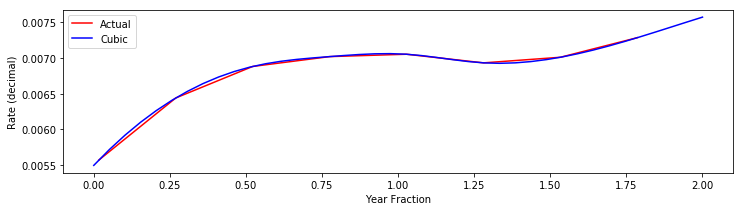

In [16]:
# Plot the actual value and fitted value
plt.figure(1, figsize=(12,3))
plt.plot(x,y,'r-',x_fit,y_fit,'b-')
plt.xlabel('Year Fraction')
plt.ylabel('Rate (decimal)')
plt.legend(['Actual','Cubic'],loc='best')
plt.show()

Figure 1 **LIBOR instantaneous rate** curves from 0 to 2 years

### 2) Fit the swap rate with scipy package

In [17]:
# Add the USD 3M to df_Swap
df_Swap=df_Swap.append(df_LIB.iloc[1],ignore_index=True)
df_Swap.sort_values(by='Year Fraction of Duration',inplace=True) # Sort the values by year fraction
df_Swap

Instruments           Start Date             End Date       Rate  \
11        USD 3M  2011-12-15 00:00:00  2012-03-15 00:00:00  0.0054625   
0   USD SWAP 02Y  2011-12-15 00:00:00  2013-12-15 00:00:00     0.0069   
1   USD SWAP 03Y  2011-12-15 00:00:00  2014-12-15 00:00:00    0.00798   
2   USD SWAP 04Y  2011-12-15 00:00:00  2015-12-15 00:00:00    0.01008   
3   USD SWAP 05Y  2011-12-15 00:00:00  2016-12-15 00:00:00    0.01248   
4   USD SWAP 07Y  2011-12-15 00:00:00  2018-12-15 00:00:00     0.0169   
5   USD SWAP 10Y  2011-12-15 00:00:00  2021-12-15 00:00:00    0.02106   
6   USD SWAP 12Y  2011-12-15 00:00:00  2023-12-15 00:00:00    0.02298   
7   USD SWAP 15Y  2011-12-15 00:00:00  2026-12-15 00:00:00    0.02478   
8   USD SWAP 20Y  2011-12-15 00:00:00  2031-12-15 00:00:00    0.02599   
9   USD SWAP 25Y  2011-12-15 00:00:00  2036-12-15 00:00:00   0.026595   
10  USD SWAP 30Y  2011-12-15 00:00:00  2041-12-15 00:00:00    0.02694   

    Year Fraction of Duration  
11                   0.252778  
0                    2.030556  
1                    3.044444  
2                    4.058333  
3                    5.075000  
4                    7.102778  
5                   10.147222  
6                   12.175000  
7                   15.219444  
8                   20.291667  
9                   25.366667  
10                  30.438889

Table 4 Combined USD 3M LIBOR with USD Swap data with ascending of year fraction

#### Compute the swap rate from scipy.interpolate for the year fraction from 0 to 31 with increment 0.05

In [18]:
x=df_Swap['Year Fraction of Duration']
y=df_Swap['Rate']
x_fit=np.linspace(0,31, num=620,endpoint=True) # 31/0.05=620, increment: 0.05
tck_swap=splrep(x,y)
y_fit=splev(x_fit,tck_swap)

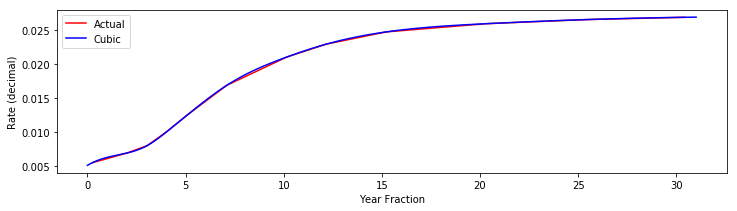

In [19]:
# Plot the actual value and fitted value
plt.figure(1, figsize=(12,3))
plt.plot(x,y,'r-',x_fit,y_fit,'b-')
plt.xlabel('Year Fraction')
plt.ylabel('Rate (decimal)')
plt.legend(['Actual','Cubic'],loc='best')
plt.show()

Figure 2 **Swap rate** curves from 0 to 31 years 

#### 3) Compute the OIS instantaneous rate 
Since the $B(t,S,T)=L(t,S,T)-F(t,S,T)$, we can compute the OIS instantaneous as following:

1. Compute LIBOR forward $L(t,S,T)$ with $S$=3M, $T$=3M,6M,9M,1Y,18M,2Y,3Y,4Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y,30Y. The instantaneous rate fo LIBOR calculated from fitted value above
2. Compute OIS forward rate $F(t,S,T)=L(t,S,T)-B(t,S,T)$
3. Compute OIS instantaneous rate from equation (12) in lecture 1

* Get the LIBOR instantaneous rate 

In [20]:
t_inst=[3/12,6/12,9/12,1,18/12,2,3,4,5,7,10,12,15,20,25,30]
rate_inst=splev(t_inst,tck_swap)
# Compute the LIBOR forward rate via the defined function LFR
forward_LIBOR=np.zeros(len(t_inst))
# Convert the year fraction to datetime objects
t0=datetime.datetime(2011,12,15)
t_date=[t0+datetime.timedelta(i*360) for i in t_inst]  
# Year fraction conversion are using 360/year in previous defined function
# This conversion makes sure that the day_frac in function LFR is the same as t_inst
for i in range(len(t_date)):
    forward_LIBOR[i]=LFR(t0,t0,t_date[i],rate_inst[i],'c')


# Compute the OIS forward rate
forward_OIS=[x-y for x,y in zip(forward_LIBOR,df_BSwap['Basis (bp)'])]


* From equation (12) in lecture 1 we can get the formula to compute the OIS instantaneous rate as following:
$$
I(t,S)=\frac{1}{\delta}\,ln(1+\delta F(t,S,T))
$$

In [21]:
# Implement the above equation
def inst_rate(S,T,Frate):
    """
    :param S: settlement date
    :param T: maturity
    :param Frate: forward rate
    """
    day_frac=date_fraction(S,T)
    
    return math.log(1+day_frac*Frate)/day_frac
    

In [22]:
# Compute the OIS instantaneous rate
inst_OIS=np.zeros(len(forward_OIS))
# This is the inverse function of LFR used to compute LIBOR(OIS) forward rate
# Therefore, S=t0, T=t_date
for i in range(len(inst_OIS)):
    inst_OIS[i]=inst_rate(t0,t_date[i],forward_OIS[i])

#### Compute the OIS instantaneous rate from scipy.interpolate for the year fraction from 0 to 31 with increment 0.05

In [23]:
# Add the 1day OIS rate
x_OIS=[1/360]
x_OIS[1:]=t_inst
y_OIS=[df_LIB.iloc[0]['Rate']]
y_OIS[1:]=inst_OIS
x_OIS_fit=np.linspace(0,31, num=620,endpoint=True) # 31/0.05=620, increment: 0.05
tck_OIS=splrep(x_OIS,y_OIS)
y_OIS_fit=splev(x_OIS_fit,tck_OIS)

In [27]:
y_OIS_fit

array([ 0.00555752,  0.00396786,  0.0027509 ,  0.00186023,  0.0012494 ,
        0.00087197,  0.00068152,  0.00063159,  0.00067576,  0.00076759,
        0.00086064,  0.00091856,  0.00094341,  0.00094641,  0.00093879,
        0.00093175,  0.00093407,  0.0009454 ,  0.00096325,  0.00098515,
        0.00100864,  0.00103173,  0.0010543 ,  0.00107664,  0.00109903,
        0.00112176,  0.00114512,  0.0011694 ,  0.00119489,  0.00122187,
        0.00125062,  0.00128136,  0.00131401,  0.00134841,  0.00138444,
        0.00142195,  0.00146079,  0.00150082,  0.00154191,  0.0015839 ,
        0.00162667,  0.00167012,  0.00171438,  0.00175962,  0.001806  ,
        0.00185369,  0.00190285,  0.00195366,  0.00200626,  0.00206084,
        0.00211755,  0.00217657,  0.00223805,  0.00230216,  0.00236908,
        0.00243895,  0.00251196,  0.00258826,  0.00266803,  0.00275142,
        0.0028386 ,  0.00292967,  0.00302449,  0.00312291,  0.00322474,
        0.00332984,  0.00343802,  0.00354912,  0.00366298,  0.00

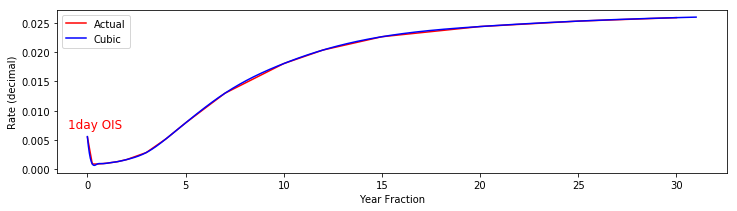

In [24]:
# Plot the actual value and fitted value
plt.figure(1, figsize=(12,3))
plt.plot(x_OIS,y_OIS,'r-',x_OIS_fit,y_OIS_fit,'b-')
plt.xlabel('Year Fraction')
plt.ylabel('Rate (decimal)')
plt.text(-1,0.007,'1day OIS',color='red',fontsize=12)
plt.legend(['Actual','Cubic'],loc='best')
plt.show()

Figure 3 **OIS instantaneous rate** curves from 0 to 31 years (1 day OIS data has been included)

### Answer of Q5

* Define a function to compute the present value of a swap. The PV of a swap is:
$$
PV=disc(t,S,T)\cdot(P^{fix} (t,S,T)-P^{float} (t,S,T))
$$

In [25]:
def PV_swap(coupon_f,frequency_f,f_f,flag_f,
            coupon_fl,frequency_fl,f_fl,flag_fl,
            t,S,maturity,Notational):
    """
    _f: parameters in fix leg
    _fl: parameters in folating leg
    :param coupon: in dollars
    :param frequency: is an int
    :param t: spot date, usually 0
    :param S: obeservation date, in datetime object
    :param maturity: in datetime object
    :param f: interest rate
    :param flag: indicator of interest rate is constant or function
    :param Notational: notational of the swap
    """
    
    # Compute the present value of fix leg
    # Compute the annuity
    flow_date_fix,flow_value_fix=calculate_flow(coupon_f,frequency_f,S,maturity)
    # compute the discount factors
    df=[]
    df_append=df.append  # avoid .operation to speed up the computation
    
    for i in range(len(flow_date_fix)):
        df_append(dist(t,flow_date_fix[i],f_f,flag_f))
    
    annuity_t=sum(a*b for a,b in zip(flow_date,df))
    
    P_fix=coupon_f*annuity_t
    
    # Compute the payment of floating leg
    # Compute the flow date
    flow_date_L, flow_cash_L=calculate_flow(coupon_fl,frequency_fl,S,maturity)
    # flow_date is delta_j in the equation (17)
    # flow_value is future cash flows
    # compute the discount factors
    df_fl=[]
    df_fl_append=df_fl.append  # avoid .operation to speed up the computation
    
    for i in range(len(flow_date_fl)):
        df_fl_append(dist(t,flow_date_fl[i],f_fl,flag_fl))
    
    # compute the Lj in equation (17)
    Lj=[]
    Lj_append=Lj.append
    
    for i in range(len(flow_date_fl)-1):
        LJ_append(LFR(0,flow_date_fl[i],flow_date_fl[i+1],f_fl,flag_fl))
    
    P_float=sum([x*y*z for x,y,z in zip(flow_date_fl,Lj,df_fl)])

    return Notational*(P_fix-P_float)
